In [1]:
# Load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import gc
import re

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_59520\2701944437.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

In [2]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'step1_GQA')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1_191124.csv'
log_path = os.path.join(outdata_f, log_file)

# Initialize Dask client
client = Client()

# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52869 instead
  warnings.warn(


In [3]:
# 1 READ URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB2B3B4Copy.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)
uc['CNTR_CODE'].fillna('AA', inplace=True)

# Select cities for processing in this batch
###uc_sel = uc.query('Batch==1.0 & CNTR_CODE != "SE"')
uc_sel = uc.query('Batch>0.0')
uc_sel = uc_sel.sort_values(by='HDENS_CLST')

# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()
len(cities_ls)

240

In [4]:
# Final GQAs
QGA_Final_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step2_GQA_Final'
# Read table with HDENS Urban centres information and Agglomerations link
HDENS_AGGL_tbl = pd.read_csv(r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\UrbanCentres_Agglomerations_csv.csv')
# Join uc code field to this table
HDENS_AGGL_tbl = HDENS_AGGL_tbl.merge(uc[['POPL_2021', 'HDENS_CLST']], on='POPL_2021')

# 1 UA DATA FOLDER
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'

# 2 READ NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')

# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

# 3 TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

In [6]:
codes_simpl = codes[['HDENS_CLST', 'HDENS_NAME', 'UA2018']]
codes_simpl['UA2018'] = codes_simpl['UA2018'].str.strip()

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_39444\3204606117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codes_simpl['UA2018'] = codes_simpl['UA2018'].str.strip()


In [7]:
codes_simpl

,HDENS_CLST,HDENS_NAME,UA2018
0,GEOSTAT21_002,Oulu / Uleåborg,FI004L4_OULU_UA2018_v013
1,GEOSTAT21_003,Umeå,SE005L1_UMEA_UA2018_v013
2,GEOSTAT21_004,Trondheim,NO003L1_TRONDHEIM_UA2018_v013
3,GEOSTAT21_005,Jyväskylä,FI009L2_JYVASKYLA_UA2018_v013
4,GEOSTAT21_006,Tampere / Tammerfors,FI002L3_TAMPERE_UA2018_v013
...,...,...,...
471,GEOSTAT21_943,Cham / Zug,not available
472,GEOSTAT21_945,Saint-Priest / Mions,FR003L2_LYON_UA2018_v013
473,GEOSTAT21_950,Fonte Nuova / Colleverde / Setteville / Case R...,IT001L3_ROMA_UA2018_v013
474,GEOSTAT21_958,Alcantarilla,ES007L2_MURCIA_UA2018_v013


In [7]:
codes_simpl = codes_simpl.drop_duplicates(ignore_index=True)
codes_simpl

,HDENS_CLST,HDENS_NAME,UA2018
0,GEOSTAT21_002,Oulu / Uleåborg,FI004L4_OULU_UA2018_v013
1,GEOSTAT21_003,Umeå,SE005L1_UMEA_UA2018_v013
2,GEOSTAT21_004,Trondheim,NO003L1_TRONDHEIM_UA2018_v013
3,GEOSTAT21_005,Jyväskylä,FI009L2_JYVASKYLA_UA2018_v013
4,GEOSTAT21_006,Tampere / Tammerfors,FI002L3_TAMPERE_UA2018_v013
...,...,...,...
402,GEOSTAT21_943,Cham / Zug,not available
403,GEOSTAT21_945,Saint-Priest / Mions,FR003L2_LYON_UA2018_v013
404,GEOSTAT21_950,Fonte Nuova / Colleverde / Setteville / Case R...,IT001L3_ROMA_UA2018_v013
405,GEOSTAT21_958,Alcantarilla,ES007L2_MURCIA_UA2018_v013


In [8]:
codes_grouped = codes_simpl.groupby(['HDENS_CLST']).size().reset_index(name='count')
codes_grouped

,HDENS_CLST,count
0,GEOSTAT21_002,1
1,GEOSTAT21_003,1
2,GEOSTAT21_004,1
3,GEOSTAT21_005,1
4,GEOSTAT21_006,1
...,...,...
394,GEOSTAT21_943,1
395,GEOSTAT21_945,1
396,GEOSTAT21_950,1
397,GEOSTAT21_958,1


In [10]:
uc_multiUA = codes_grouped.query('count>1').merge(codes[['HDENS_CLST', 'HDENS_NAME']], how='left', on='HDENS_CLST').drop_duplicates(ignore_index=True)
uc_multiUA['ncm_layer_path'] = 'Noise_20202025_export.gpkg'
uc_multiUA.loc[1:3, 'ncm_layer_path'] = 'Noise_20202025_export_DE_update_v2.gpkg'
uc_multiUA.loc[7, 'ncm_layer_path'] = 'Noise_20202025_export_DE_update_v2.gpkg'
uc_multiUA['ncm_layer_name'] = 0
uc_multiUA.loc[0, 'ncm_layer_name'] = 'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_NL'
uc_multiUA.loc[1:3, 'ncm_layer_name'] = 'ncm_DE_upd'
uc_multiUA.loc[4:5,'ncm_layer_name'] = 'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_DE'
uc_multiUA.loc[6,'ncm_layer_name'] = 'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_CH'
uc_multiUA.loc[7, 'ncm_layer_name'] = 'ncm_DE_upd'
uc_multiUA.loc[8, "HDENS_CLST"] = "GEOSTAT21_901"
uc_multiUA.loc[8, "HDENS_NAME"] = "Helsinki"
uc_multiUA.loc[8, "ncm_layer_path"] = "Noise_20202025_export.gpkg"
uc_multiUA.loc[8, "ncm_layer_name"] = 'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_FI'
uc_multiUA.loc[9, "HDENS_CLST"] = "GEOSTAT21_650"
uc_multiUA.loc[9, "HDENS_NAME"] = "Bilbao"
uc_multiUA.loc[9, "ncm_layer_path"] = "Noise_20202025_export.gpkg"
uc_multiUA.loc[9, "ncm_layer_name"] = 'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_ES'

uc_multiUA

,HDENS_CLST,count,HDENS_NAME,ncm_layer_path,ncm_layer_name
0,GEOSTAT21_222,2.0,Pijnacker / Berkel en Rodenrijs,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...
1,GEOSTAT21_297,2.0,Moers / Rheinhausen,Noise_20202025_export_DE_update_v2.gpkg,ncm_DE_upd
2,GEOSTAT21_334,2.0,Solingen,Noise_20202025_export_DE_update_v2.gpkg,ncm_DE_upd
3,GEOSTAT21_363,2.0,Bonn,Noise_20202025_export_DE_update_v2.gpkg,ncm_DE_upd
4,GEOSTAT21_405,2.0,Wiesbaden,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...
5,GEOSTAT21_408,2.0,Mainz,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...
6,GEOSTAT21_511,2.0,Winterthur,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...
7,GEOSTAT21_925,2.0,Wuppertal,Noise_20202025_export_DE_update_v2.gpkg,ncm_DE_upd
8,GEOSTAT21_901,NaN,Helsinki,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...
9,GEOSTAT21_650,NaN,Bilbao,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...


In [60]:
cities_ls = uc_multiUA.HDENS_CLST.to_list()

In [112]:
cities_ls

['GEOSTAT21_222',
 'GEOSTAT21_297',
 'GEOSTAT21_334',
 'GEOSTAT21_363',
 'GEOSTAT21_405',
 'GEOSTAT21_408',
 'GEOSTAT21_511',
 'GEOSTAT21_925']

In [14]:
cities_ls =  [
 'GEOSTAT21_334']

In [16]:
uc_city_code = 'GEOSTAT21_334'
codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[1].strip()

'DE011L1_DUSSELDORF_UA2018_v013'

In [5]:
cities_ls = ['GEOSTAT21_012',
'GEOSTAT21_021',
'GEOSTAT21_302',
'GEOSTAT21_305',
'GEOSTAT21_328',
'GEOSTAT21_344']


In [ ]:
counter= 1
agl_error_ls = []

# Loop through test cities
for uc_city_code in cities_ls[:-1]:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))

    inGQA = os.path.join(QGA_Final_path, '{}_finalGQA.shp'.format(uc_city_code))
    if not os.path.exists(inGQA):
        try:
            urban_center = uc.query(f'HDENS_CLST=="{uc_city_code}"')
            uc_name = codes.query(f'HDENS_CLST=="{uc_city_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")
            ctry_code = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()[:2]
            print(f"{ctry_code} - {uc_name}")

            agl_city = gpd.clip(agls, urban_center)

            # Check noise contour maps GeoPackage file
            if ctry_code == 'DE':
                ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_DE_update.gpkg')
            else:
                ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
            layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'                   
            ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
            print ("ncm")
            ncm = gpd.clip(ncm, urban_center)

            # Define the list of noisy classes
            noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
            print(noisy_classes)
            # Create a condition based on the category column
            condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

            # Specify the condition and create a new category column based on the condition
            ncm['noisy'] = 0
            ncm.loc[condition, 'noisy'] = 1
            ncm = ncm[['noisy', 'geometry']]
            print(ncm)
            ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
            ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
            print ("ncm_dis")

            # Perform spatial overlay (intersection) 
            ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
            print ("ncm_agl")
            
            # Aggregate the area with lower band values (quieter bands)
            ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
            print ("union")

            ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
            print ("fillna")

            # Select a subset of columns of interest
            ncm_dis = ncm_agl_city[['noisy', 'geometry']]
            print(ncm_dis)
                                
            # 3 READ URBAN ATLAS DATA 
            group_combinations = codes.query(f'HDENS_CLST=="{uc_city_code}"')[['HDENS_CLST', 'UA2018']].drop_duplicates()
            group_combinations = group_combinations.groupby(['HDENS_CLST', 'UA2018']).size().reset_index(name='count')
            ua_ls = group_combinations['UA2018'].tolist()
            print(ua_ls)
            if len(ua_ls)==1:
                ua_path = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()
                file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
                # Read the GeoPackage file
                ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                            columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                print ("loaded ua in urban city") 
            else:
                ua_path1 = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()
                ua_path2 = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[1].strip()
                file_path1 = os.path.join(ua_data_f, f'{ua_path1}\Data\{ua_path1}.gpkg')
                file_path2 = os.path.join(ua_data_f, f'{ua_path2}\Data\{ua_path2}.gpkg')
                # Read the GeoPackage file
                ua1 = gpd.read_file(file_path1, layer= ua_path1[:-5], 
                            columns= ['code_2018','Pop2018','geometry'], 
                            engine='pyogrio', 
                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                ua2 = gpd.read_file(file_path2, layer= ua_path2[:-5], 
                            columns= ['code_2018','Pop2018','geometry'], 
                            engine='pyogrio', 
                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                
                ua1 = gpd.clip(ua1, urban_center)
                ua2 = gpd.clip(ua2, urban_center)
                ua = pd.concat([ua1, ua2], ignore_index=True)
                print ("loaded ua in urban city")   
            
            # Select 'green' classes
            uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
            print("Selected 'green' classes")

            # 4 SELECT UA INTERSECTING UC
            # Perform spatial overlay (intersection)
            uagreen_urbc = gpd.overlay(uagreen, urban_center, how='intersection')
            print("Selected UA INTERSECTING UC")

            # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
            # Perform spatial overlay (intersection)
            nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
            print('nqgreen')

            # 6 IDENTIFY QUIET/NOISY AREAS
            ## for statistics need to calculate area again
            # Calculate the area for each geometry and create a new column 'area'
            nqgreen['area_m2'] = nqgreen['geometry'].area
            nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
            nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
            nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
            nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
            nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

            # 7 EXPORT GREEN QUIET AREAS (GQA)
            # discriminate noisy and quiet
            nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
            print('subset columns in nqgreen')
            GQA = nqgreen.query('noisy == 0')
            GNA = nqgreen.query('noisy == 1')

            # multipart to single part
            GQA_sp = GQA.explode(index_parts=True)
            print('multipart to single part')
            # Reset index to keep it clean
            GQA_sp = GQA_sp.reset_index(drop=True)

            # Select those areas bigger than 100 m2
            GQA = GQA_sp[GQA_sp.geometry.area > 100]
            print('Select those areas bigger than 100 m2')

            # Export to shapefile
            print ('Export to shapefile')
            GQA.to_file(inGQA, driver='ESRI Shapefile')
            print ("GQA")
    
            # Calculate the duration
            end_time = datetime.now()
            processing_time = end_time - start_time
            print ("str(processing_time)")
            
        except:
            print("Error " + uc_city_code)
            agl_error_ls.append(uc_city_code +" error")
    counter= counter+1

print(agl_error_ls)

In [8]:
urban_center

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,geometry
152,GEOSTAT21_344,Leuven,GEOSTAT11_344,77260.0,BE,1,21000000.0,24000.0,1.0,2100.0,"POLYGON ((3949000.000 3096000.000, 3948000.000..."


In [24]:
GQA

,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,2326.376387,0.23,0.00,"POLYGON Z ((4111563.558 3118034.681 0.000, 411..."
1,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,93394.570513,9.34,0.09,"POLYGON Z ((4111626.983 3118305.304 0.000, 411..."
2,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,112315.204059,11.23,0.11,"POLYGON Z ((4111894.364 3118712.576 0.000, 411..."
3,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,24738.791608,2.47,0.02,"POLYGON Z ((4112984.661 3118306.417 0.000, 411..."
4,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,24738.791608,2.47,0.02,"POLYGON Z ((4113000.000 3118436.351 0.000, 411..."
...,...,...,...,...,...,...,...,...,...,...,...
1857,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1091.045915,0.11,0.00,"POLYGON Z ((4108262.217 3119438.844 0.000, 410..."
1858,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1091.045915,0.11,0.00,"POLYGON Z ((4108172.412 3119430.084 0.000, 410..."
1860,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1152.305842,0.12,0.00,"POLYGON Z ((4105091.642 3123137.780 0.000, 410..."
1862,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1152.305842,0.12,0.00,"POLYGON Z ((4105183.802 3123426.406 0.000, 410..."


In [20]:
nqgreen

,country,fua_name,fua_code,code_2018,class_2018,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,noisy,geometry
0,DE,Solingen,DE516L0,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,"POLYGON Z ((4111646.132 3118062.206 0.000, 411..."
1,DE,Solingen,DE516L0,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,MULTIPOLYGON Z (((4111338.775 3118182.030 0.00...
2,DE,Solingen,DE516L0,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,"POLYGON Z ((4111835.438 3118414.696 0.000, 411..."
3,DE,Solingen,DE516L0,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,MULTIPOLYGON Z (((4112960.766 3118479.775 0.00...
4,DE,Solingen,DE516L0,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,MULTIPOLYGON Z (((4113063.480 3119018.884 0.00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,DE,Düsseldorf,DE011L1,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,"POLYGON Z ((4105080.551 3123136.651 0.000, 410..."
294,DE,Düsseldorf,DE011L1,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,"POLYGON Z ((4105006.055 3123386.426 0.000, 410..."
295,DE,Düsseldorf,DE011L1,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,1.0,"POLYGON Z ((4105299.042 3123326.945 0.000, 410..."
296,DE,Düsseldorf,DE011L1,31000,Forests,GEOSTAT21_334,Solingen,GEOSTAT11_334,235527.0,DE,1,79000000.0,60000.0,4.0,7900.0,0.0,MULTIPOLYGON Z (((4105091.642 3123137.780 0.00...


In [145]:
uc_multiUA.query(f'HDENS_CLST=="{uc_city_code}"')

,HDENS_CLST,count,HDENS_NAME,ncm_layer_path,ncm_layer_name
4,GEOSTAT21_405,2,Wiesbaden,Noise_20202025_export.gpkg,dbo.DF48_agg_NoiseContours_roadsInAgglomeratio...


In [147]:
uc_multiUA.query(f'HDENS_CLST=="{uc_city_code}"').ncm_layer_name.values[0]

'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_NL'

In [136]:
layerName

'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_NL'

In [11]:
cities_ls3 = ['GEOSTAT21_650',
 'GEOSTAT21_901']

In [18]:
cities_ls4 = ['GEOSTAT21_334']

In [36]:
counter= 1
agl_error_ls = []

# Loop through test cities
for uc_city_code in cities_ls4:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))

    urban_center = uc.query(f'HDENS_CLST=="{uc_city_code}"')
    uc_name = codes_simpl.query(f'HDENS_CLST=="{uc_city_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")
    ctry_code = codes_simpl.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()[:2]
    print(f"{ctry_code} - {uc_city_code} - {uc_name}")

    ua_path1 = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()
    ua_path2 = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[1].strip()
    if ua_path1 == 'not available' or ua_path2 == 'not available':
        agl_error_ls.append(uc_city_code +" UA not available")
    
    else:
        inGQA = os.path.join(QGA_Final_path, '{}_finalGQA.shp'.format(uc_city_code))
        if not os.path.exists(inGQA):
            try:


                agl_city = gpd.clip(agls, urban_center)

                # Check noise contour maps GeoPackage file
                ncm_file_path_gpkg = uc_multiUA.query(f'HDENS_CLST=="{uc_city_code}"').ncm_layer_path.values[0]
                ncm_file_path_layer = uc_multiUA.query(f'HDENS_CLST=="{uc_city_code}"').ncm_layer_name.values[0]
                ncm_file_path = os.path.join(indata_f, 'NoiseData', ncm_file_path_gpkg)
                layerName = ncm_file_path_layer           
                ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                    engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                print ("ncm")
                ncm = gpd.clip(ncm, urban_center)

                # Define the list of noisy classes
                noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
                print(noisy_classes)
                # Create a condition based on the category column
                condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                # Specify the condition and create a new category column based on the condition
                ncm['noisy'] = 0
                ncm.loc[condition, 'noisy'] = 1
                ncm = ncm[['noisy', 'geometry']]
                print(ncm)
                ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                print ("ncm_dis")

                # Perform spatial overlay (intersection) 
                ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                print ("ncm_agl")
                
                # Aggregate the area with lower band values (quieter bands)
                ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                print ("union")

                ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                print ("fillna")

                # Select a subset of columns of interest
                ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                print(ncm_dis)
                                    
                # 3 READ URBAN ATLAS DATA       
                file_path1 = os.path.join(ua_data_f, f'{ua_path1}\Data\{ua_path1}.gpkg')
                file_path2 = os.path.join(ua_data_f, f'{ua_path2}\Data\{ua_path2}.gpkg')
                # Read the GeoPackage file
                ua1 = gpd.read_file(file_path1, layer= ua_path1[:-5], 
                            columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], 
                            engine='pyogrio', 
                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                ua2 = gpd.read_file(file_path2, layer= ua_path2[:-5], 
                            columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], 
                            engine='pyogrio', 
                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                print ("loaded ua in urban city")
                ua1 = gpd.clip(ua1, urban_center)
                ua2 = gpd.clip(ua2, urban_center)
                ua = pd.concat([ua1, ua2], ignore_index=True)                   

                # Select 'green' classes
                uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                
                # 4 SELECT UA INTERSECTING UC
                # Perform spatial overlay (intersection)
                uagreen_urbc = gpd.overlay(uagreen, urban_center, how='intersection')

                # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                # Perform spatial overlay (intersection)
                nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                #not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                # Filter out empty polygons(not empty polygons)
                #green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                # save to shapefile
                file_path = os.path.join(outdata_f, f'{uc_city_code}_green_not_covered_by_ncm.shp')
                #green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                print ("green_not_covered_by_ncm")

                # 6 IDENTIFY QUIET/NOISY AREAS
                ## for statistics need to calculate area again
                # Calculate the area for each geometry and create a new column 'area'
                nqgreen['area_m2'] = nqgreen['geometry'].area
                nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                # 7 EXPORT GREEN QUIET AREAS (GQA)
                # discriminate noisy and quiet
                nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                GQA = nqgreen.query('noisy == 0')
                GNA = nqgreen.query('noisy == 1')

                # multipart to single part
                GQA_sp = GQA.explode(index_parts=True)
                # Reset index to keep it clean
                GQA_sp = GQA_sp.reset_index(drop=True)

                # Select those areas bigger than 100 m2
                GQA = GQA_sp[GQA_sp.geometry.area > 100]

                # Export to shapefile
                print ('Export to shapefile')
                GQA.to_file(inGQA, driver='ESRI Shapefile')
                print ("GQA")

                # 8 CREATE CENTROIDS FOR GQA POLYGONS
                # Create a new GeoDataFrame with centroids as points
                GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                GQA_pts['oid'] = GQA.index
                GQA_pts['fua_name'] = GQA.fua_name
                GQA_pts['fua_code'] = GQA.fua_code
                GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                # Export to shapefile
                file_path = os.path.join(outdata_f, f'{uc_city_code}_GQA_centroids.shp')
                GQA_pts.to_file(file_path, driver='ESRI Shapefile')

                print ("GQA_pts")
        
                # Calculate the duration
                end_time = datetime.now()
                processing_time = end_time - start_time

                print ("str(processing_time)")
                
                ## write output values into log file
                uc_km2 = round(uc_city.area.sum()/1000000,2)
                agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                ua_km2 = round(ua.area.sum()/1000000,2)
                uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                nqgreen_m2 = round(nqgreen.area.sum(),2)
                green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                GQA_m2 = round(GQA.area.sum(),2)
                GNA_m2 = round(GNA.area.sum(),2)
                processing_duration = str(processing_time)

                log_entry = create_log_entry(uc_name, uc_city_code, uc_km2, agl_city_km2, 
                                        ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                        green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                write_log(log_path, log_entry)

                # Clean up intermediate variables to free memory
                del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
            except:
                print("Error " + uc_city_code)
                agl_error_ls.append(uc_city_code +" Topological error")
    counter= counter+1

print(agl_error_ls)

1
2024-11-20 11:10:59.712485
DE - GEOSTAT21_334 - Solingen
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON Z (((4105060.053 3123994.863 0.00...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON Z (((4107865.879 3120013.341 0.00...
1    1.0  POLYGON Z ((4105067.864 3123834.689 0.000, 410...
2    1.0  POLYGON Z ((4105286.701 3123441.525 0.000, 410...
3    0.0  MULTIPOLYGON Z (((4120000.000 3121000.000 0.00...
4    0.0  MULTIPOLYGON Z (((4105314.359 3123184.741 0.00...
loaded ua in urban city
green_not_covered_by_ncm
Export to shapefile
GQA
GQA_pts
str(processing_time)
Error GEOSTAT21_334
['GEOSTAT21_334 Topological error']


In [40]:
#GQA = GQA_sp[GQA_sp.geometry.area > 100]
GQA

,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,2326.376387,0.23,0.00,"POLYGON Z ((4111563.558 3118034.681 0.000, 411..."
1,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,93394.570513,9.34,0.09,"POLYGON Z ((4111626.983 3118305.304 0.000, 411..."
2,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,112315.204059,11.23,0.11,"POLYGON Z ((4111894.364 3118712.576 0.000, 411..."
3,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,24738.791608,2.47,0.02,"POLYGON Z ((4112984.661 3118306.417 0.000, 411..."
4,DE,Solingen,DE516L0,GEOSTAT11_334,31000,Forests,0.0,24738.791608,2.47,0.02,"POLYGON Z ((4113000.000 3118436.351 0.000, 411..."
...,...,...,...,...,...,...,...,...,...,...,...
1857,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1091.045915,0.11,0.00,"POLYGON Z ((4108262.217 3119438.844 0.000, 410..."
1858,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1091.045915,0.11,0.00,"POLYGON Z ((4108172.412 3119430.084 0.000, 410..."
1860,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1152.305842,0.12,0.00,"POLYGON Z ((4105091.642 3123137.780 0.000, 410..."
1862,DE,Düsseldorf,DE011L1,GEOSTAT11_334,31000,Forests,0.0,1152.305842,0.12,0.00,"POLYGON Z ((4105183.802 3123426.406 0.000, 410..."


In [20]:
ua

,country,fua_name,fua_code,code_2018,class_2018,geometry
0,DE,Solingen,DE516L0,23000,Pastures,"POLYGON ((4110939.196 3117005.429, 4110944.892..."
1,DE,Solingen,DE516L0,11220,Discontinuous medium density urban fabric (S.L...,"POLYGON ((4110993.537 3117060.678, 4111000.000..."
2,DE,Solingen,DE516L0,32000,Herbaceous vegetation associations (natural gr...,"POLYGON ((4110805.054 3117000.000, 4110806.379..."
3,DE,Solingen,DE516L0,23000,Pastures,"POLYGON ((4110679.127 3117021.549, 4110683.362..."
4,DE,Solingen,DE516L0,11220,Discontinuous medium density urban fabric (S.L...,"POLYGON ((4110959.533 3117184.443, 4110959.685..."
...,...,...,...,...,...,...
3223,DE,Düsseldorf,DE011L1,50000,Water,"MULTIPOLYGON (((4105045.168 3123806.082, 41050..."
3224,DE,Düsseldorf,DE011L1,21000,Arable land (annual crops),"POLYGON ((4105583.858 3123870.008, 4105582.353..."
3225,DE,Düsseldorf,DE011L1,12100,"Industrial, commercial, public, military and p...","POLYGON ((4105068.353 3123919.118, 4105072.474..."
3226,DE,Düsseldorf,DE011L1,11210,Discontinuous dense urban fabric (S.L. : 50% -...,"POLYGON ((4105315.894 3123997.029, 4105313.369..."


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_14688\159643537.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


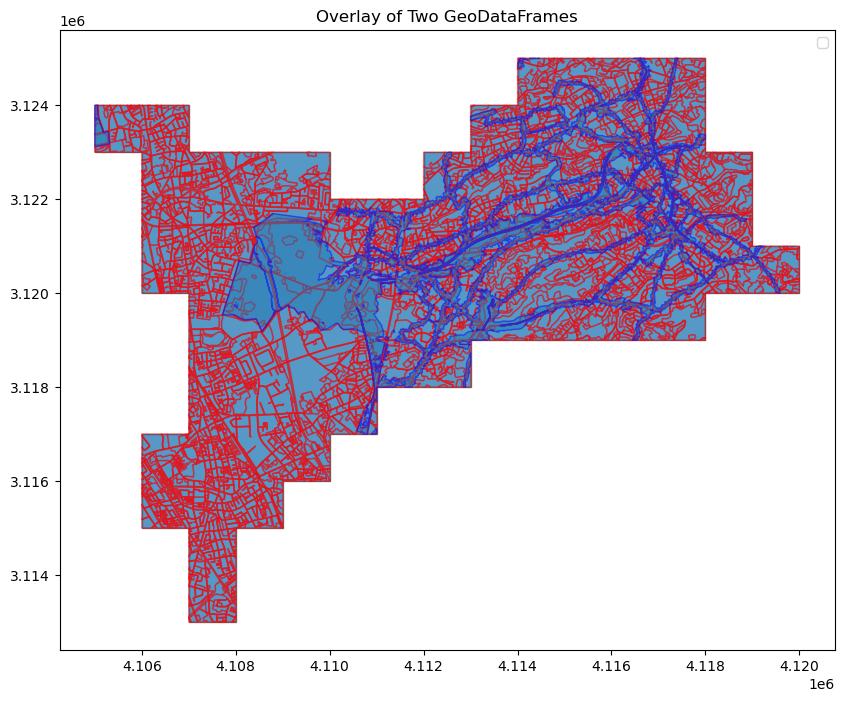

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
urban_center.plot(ax=ax, edgecolor='black', facecolor=None, alpha=0.5, label='Layer 1')  # Customize color and alpha
ua.plot(ax=ax, edgecolor='red', facecolor=None, alpha=0.5, label='Layer 2')  # Customize color and alpha
ncm.plot(ax=ax, edgecolor='blue', facecolor=None, alpha=0.5, label='Layer 3') 

# Add a legend and title
plt.legend()
plt.title("Overlay of Two GeoDataFrames")

# Show the plot
plt.show()


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_14688\2713509735.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


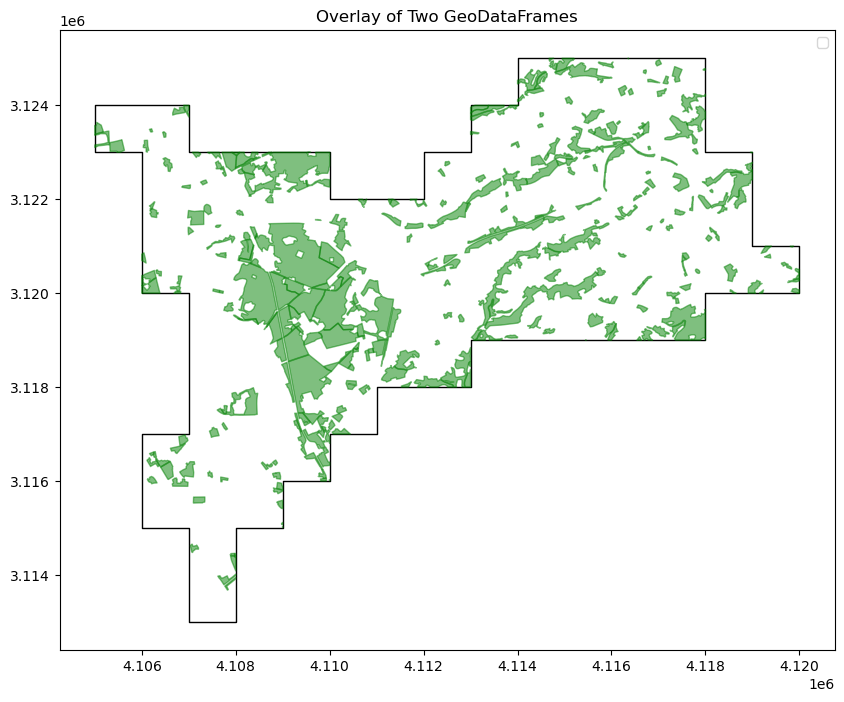

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
urban_center.plot(ax=ax, edgecolor='black', facecolor='none', alpha=1, label='Layer 1')  # Customize color and alpha
uagreen_urbc.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.5, label='Layer 2')  # Customize color and alpha


# Add a legend and title
plt.legend()
plt.title("Overlay of Two GeoDataFrames")

# Show the plot
plt.show()

Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_14688\1719138148.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


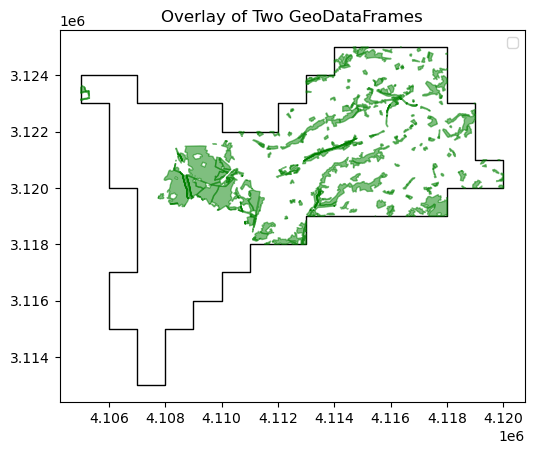

In [32]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
urban_center.plot(ax=ax, edgecolor='black', facecolor='none', alpha=1, label='Layer 1')  # Customize color and alpha
nqgreen.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.5, label='Layer 2')  # Customize color and alpha


# Add a legend and title
plt.legend()
plt.title("Overlay of Two GeoDataFrames")

# Show the plot
plt.show()

Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_14688\1156079176.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


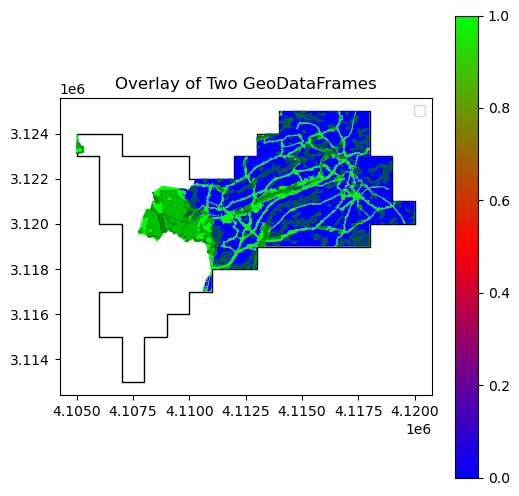

In [39]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
urban_center.plot(ax=ax, edgecolor='black', facecolor='none', alpha=1, label='Layer 1')  # Customize color and alpha
ncm_dis.plot(ax=ax, column='noisy', legend=True, cmap='brg') 
nqgreen.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.5, label='Layer 2')  # Customize color and alpha

# Add a legend and title
plt.legend()
plt.title("Overlay of Two GeoDataFrames")

# Show the plot
plt.show()

In [37]:
ncm_dis

,noisy,geometry
0,1.0,MULTIPOLYGON Z (((4107865.879 3120013.341 0.00...
1,1.0,"POLYGON Z ((4105067.864 3123834.689 0.000, 410..."
2,1.0,"POLYGON Z ((4105286.701 3123441.525 0.000, 410..."
3,0.0,MULTIPOLYGON Z (((4120000.000 3121000.000 0.00...
4,0.0,MULTIPOLYGON Z (((4105314.359 3123184.741 0.00...


In [ ]:
nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
# Filter out empty polygons(not empty polygons)
green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

In [35]:
not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


GEOSException: TopologyException: found non-noded intersection between LINESTRING (4.10844e+06 3.12123e+06, 4.10843e+06 3.1212e+06) and LINESTRING (4.10843e+06 3.12122e+06, 4.10841e+06 3.12131e+06) at 4108434.5912512341 3121222.5499590365 0

Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_14688\3484850130.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


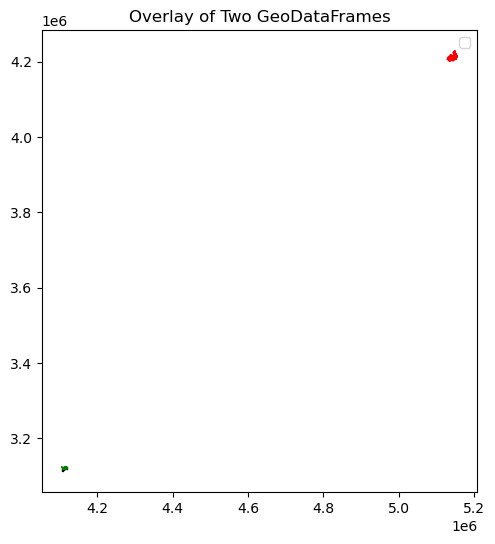

In [34]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
urban_center.plot(ax=ax, edgecolor='black', facecolor='none', alpha=1, label='Layer 1')  # Customize color and alpha
nqgreen.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.5, label='Layer 2')  # Customize color and alpha
not_covered.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.5, label='Layer 3') 

# Add a legend and title
plt.legend()
plt.title("Overlay of Two GeoDataFrames")

# Show the plot
plt.show()

<AxesSubplot: >

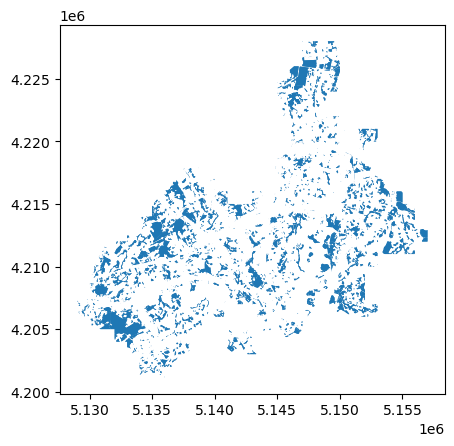

In [21]:
GQA.plot()

<AxesSubplot: >

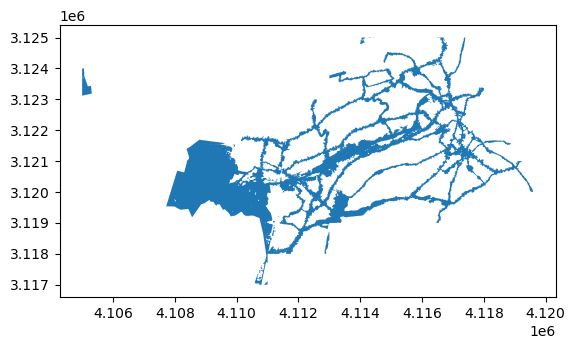

In [22]:
ncm.plot()